https://www.coursera.org/lecture/convolutional-neural-networks/anchor-boxes-yNwO0
    
https://towardsdatascience.com/understanding-ssd-multibox-real-time-object-detection-in-deep-learning-495ef744fab
    
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

https://medium.com/@jonathan_hui/ssd-object-detection-single-shot-multibox-detector-for-real-time-processing-9bd8deac0e06

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import shutil
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../fastai/")
from fastai.conv_learner import *

In [3]:
path = Path("../DATA/airbus-ship/")
files = list(path.iterdir())

In [4]:
list(path.glob("*/**"))

[PosixPath('../DATA/airbus-ship/segmentations'),
 PosixPath('../DATA/airbus-ship/segmentations/test_masks'),
 PosixPath('../DATA/airbus-ship/segmentations/train_masks'),
 PosixPath('../DATA/airbus-ship/classification'),
 PosixPath('../DATA/airbus-ship/detections'),
 PosixPath('../DATA/airbus-ship/detections/resnet_v1_101_2016_08_28'),
 PosixPath('../DATA/airbus-ship/test_dummy'),
 PosixPath('../DATA/airbus-ship/test_all'),
 PosixPath('../DATA/airbus-ship/tmp'),
 PosixPath('../DATA/airbus-ship/models'),
 PosixPath('../DATA/airbus-ship/train_all')]

### visualize detection data

In [8]:
from skimage.measure import regionprops
from eval_metric import get_gt_masks
from seg_plots import show_imgmasks

In [9]:
# images with ships
train_seg_lbs = pd.read_csv(path/"segmentations/train_seg_lbs.csv")
test_seg_lbs = pd.read_csv(path/"segmentations/test_seg_lbs.csv")

In [7]:
ship_id = np.random.choice(train_seg_lbs.ImageId)
gt_rles = train_seg_lbs[train_seg_lbs.ImageId == ship_id]['EncodedPixels'].values
len(gt_rles)

12

In [8]:
img = open_image(path/"train_all"/ship_id)

In [9]:
gt_masks = get_gt_masks(gt_rles)

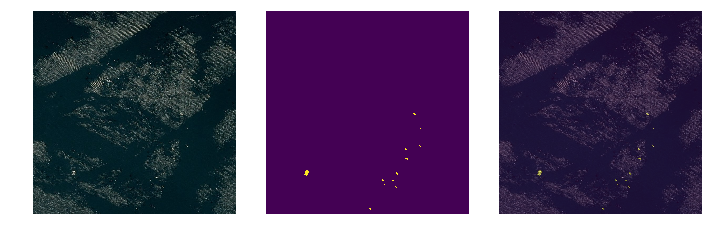

In [10]:
show_imgmasks(img, sum(gt_masks))

In [11]:
props = [regionprops(gt_mask) for gt_mask in gt_masks]

In [12]:
bboxes = [prop[0]['bbox'] for prop in props]

In [13]:
props

[[<skimage.measure._regionprops._RegionProperties at 0x7fc94ffed4e0>],

In [14]:
from detect_plots import draw_bbox

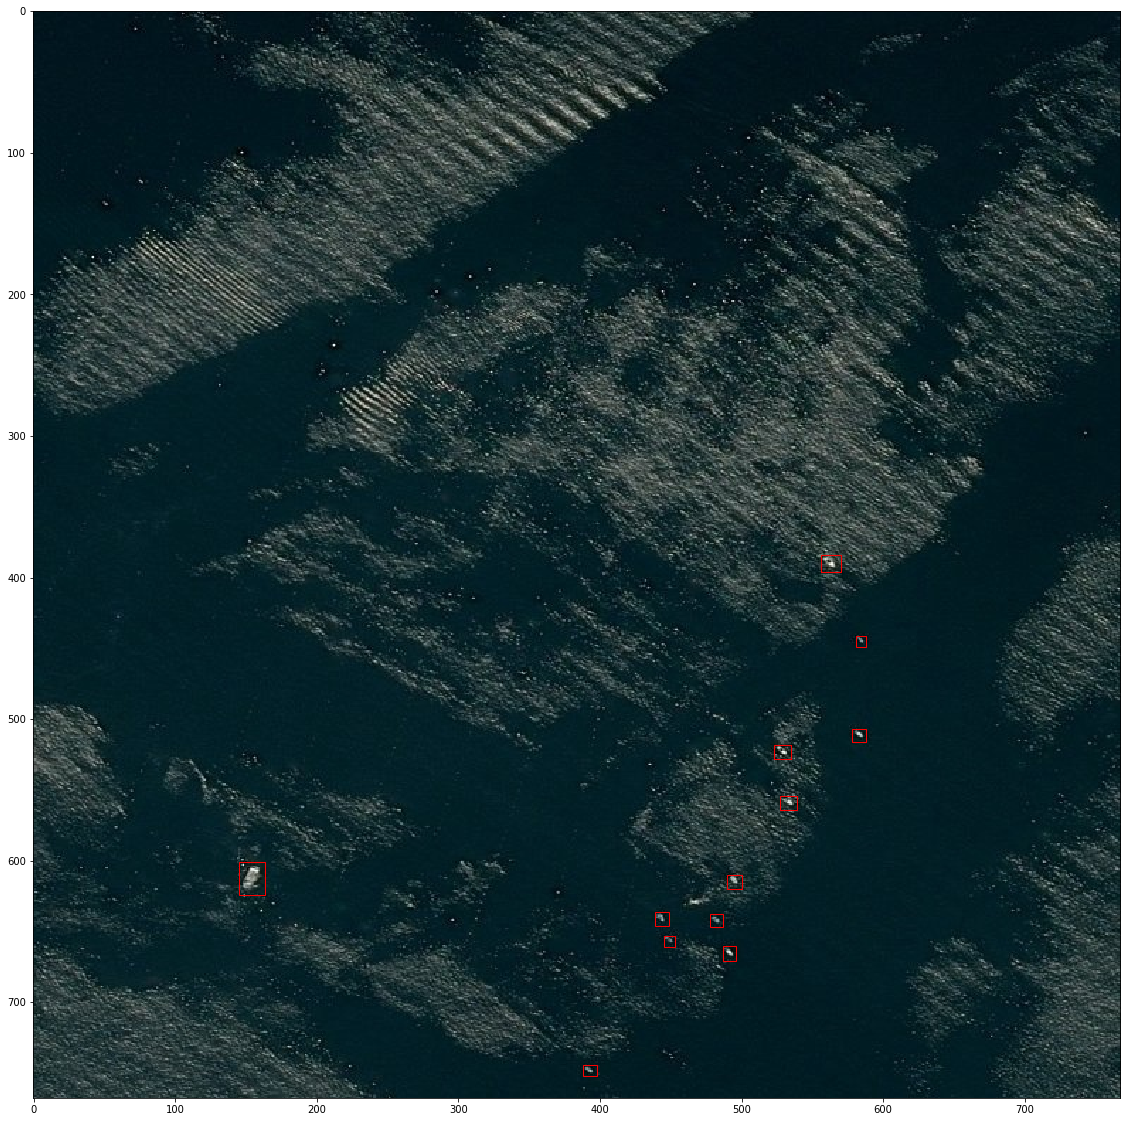

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
axes.imshow(img)
for bbox in bboxes: draw_bbox(bbox, axes)

### create object detection data

In [196]:
train_ship_ids = train_seg_lbs.ImageId.unique()
test_ship_ids = test_seg_lbs.ImageId.unique()

#### train

In [ ]:
df = train_seg_lbs
ship_id_bbox = []

for img_id in train_ship_ids:
    gt_rles = df[df.ImageId == img_id]['EncodedPixels'].values
    gt_masks = get_gt_masks(gt_rles)
    props = [regionprops(gt_mask) for gt_mask in gt_masks]
    bboxes = [prop[0]['bbox'] for prop in props]
    n = len(ship_id_bbox)
    for bbox in bboxes: ship_id_bbox.append((img_id, bbox))

In [ ]:
ship_ids, bboxes = list(zip(*ship_id_bbox))
train_bbox_lbs = pd.DataFrame({"ImageId": ship_ids, "BoundingBox": bboxes})

#### test

In [ ]:
df = test_seg_lbs
ship_id_bbox = []

for img_id in test_ship_ids:
    gt_rles = df[df.ImageId == img_id]['EncodedPixels'].values
    gt_masks = get_gt_masks(gt_rles)
    props = [regionprops(gt_mask) for gt_mask in gt_masks]
    bboxes = [prop[0]['bbox'] for prop in props]
    n = len(ship_id_bbox)
    for bbox in bboxes: ship_id_bbox.append((img_id, bbox))

In [219]:
ship_ids, bboxes = list(zip(*ship_id_bbox))
test_bbox_lbs = pd.DataFrame({"ImageId": ship_ids, "BoundingBox": bboxes})

#### save files

In [223]:
os.makedirs(path/"detections", exist_ok=True)

train_bbox_lbs.to_csv(path/"detections/train_bbox_lbs.csv", index=False)
test_bbox_lbs.to_csv(path/"detections/test_bbox_lbs.csv", index=False)

### model - ...

https://arxiv.org/pdf/1806.04331.pdf

https://arxiv.org/pdf/1711.09405.pdf

**TODO:** dynamic feature pyramidal network

In [5]:
train_bbox_lbs = pd.read_csv(path/"detections/train_bbox_lbs.csv")
test_bbox_lbs = pd.read_csv(path/"detections/test_bbox_lbs.csv")

In [6]:
# min row, min col, max row, max col
print(train_bbox_lbs.shape)
train_bbox_lbs.head()

(73605, 2)


,ImageId,BoundingBox
0,000155de5.jpg,"(465, 344, 501, 448)"
1,00021ddc3.jpg,"(732, 131, 762, 168)"
2,00021ddc3.jpg,"(755, 123, 767, 136)"
3,00021ddc3.jpg,"(715, 96, 720, 107)"
4,00021ddc3.jpg,"(661, 195, 665, 201)"


In [7]:
train_bbox_lbs.BoundingBox = train_bbox_lbs.BoundingBox.apply(lambda x: x[1:-1].replace(",", ""))
test_bbox_lbs.BoundingBox = test_bbox_lbs.BoundingBox.apply(lambda x: x[1:-1].replace(",", ""))

In [8]:
train_bbox_lbs = train_bbox_lbs.groupby("ImageId").apply(lambda x: " ".join(x['BoundingBox'])).reset_index().rename(columns={0:'BoundingBox'})
test_bbox_lbs = test_bbox_lbs.groupby("ImageId").apply(lambda x: " ".join(x['BoundingBox'])).reset_index().rename(columns={0:'BoundingBox'})

In [9]:
train_bbox_lbs.to_csv(path/"detections/train_bbox_lbs2.csv", index=False)
test_bbox_lbs.to_csv(path/"detections/test_bbox_lbs2.csv", index=False)

In [10]:
train_bbox_lbs.shape, test_bbox_lbs.shape

((38300, 2), (4256, 2))

### construct SSD data

image_id, bounding_box, clas_id

001.jpg, 0 0 100 100 10 10 150 150, 1 1 

In [11]:
train_bbox_lbs = pd.read_csv(path/"detections/train_bbox_lbs2.csv")
test_bbox_lbs = pd.read_csv(path/"detections/test_bbox_lbs2.csv")

In [12]:
train_bbox_lbs.sample(30).to_csv(path/"detections/train_bbox_lbs2_sml.csv", index=False)

In [13]:
train_bbox_lbs.head(2)

,ImageId,BoundingBox
0,000155de5.jpg,465 344 501 448
1,000194a2d.jpg,377 67 386 85 287 469 307 492 178 331 197 370 ...


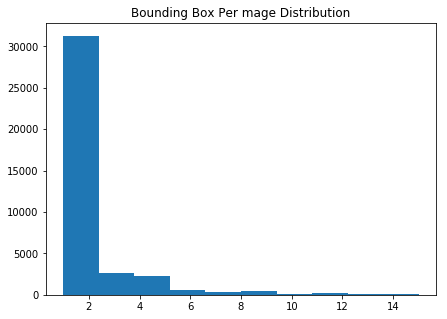

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
axes.set_title("Bounding Box Per mage Distribution")
axes.hist(train_bbox_lbs['BoundingBox'].apply(lambda x: len((x).split(" "))//4))
plt.show()

### show bboxes

Images have different levels of zoom

In [15]:
from detect_plots import draw_bbox, draw_bbox_on_img

In [16]:
len(train_bbox_lbs), len(test_bbox_lbs)

(38300, 4256)

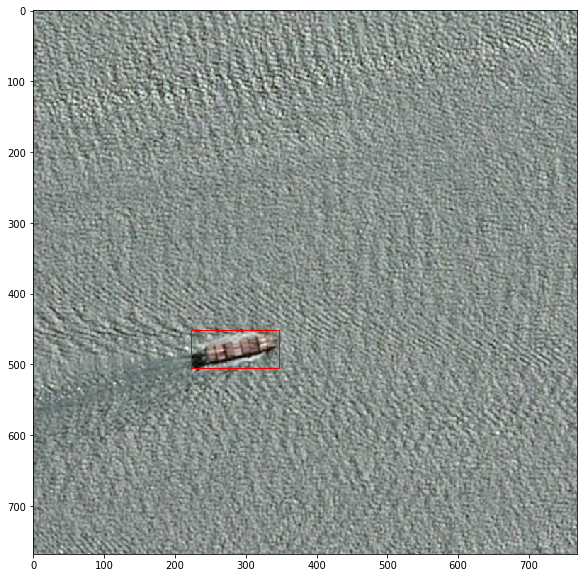

In [17]:
i = 80
img_id, bboxes = train_bbox_lbs.iloc[i]['ImageId'], train_bbox_lbs.iloc[i]['BoundingBox']
bboxes = np.array(bboxes.split(" "), dtype=np.int32).reshape(-1, 4).tolist()
img = open_image(path/f"train_all/{img_id}")
draw_bbox_on_img(img, bboxes)

### filter images with single object

In [18]:
single_object_mask = train_bbox_lbs['BoundingBox'].apply(lambda x: len(x.split(" "))//4) == 1

In [19]:
train_bbox_lbs_single = train_bbox_lbs[single_object_mask].reset_index(drop=True)

In [20]:
train_bbox_lbs_single.to_csv(path/"detections/train_bbox_lbs2_single.csv", index=False)

In [21]:
train_bbox_lbs_single.head()

,ImageId,BoundingBox
0,000155de5.jpg,465 344 501 448
1,00031f145.jpg,124 443 153 472
2,00053c6ba.jpg,124 736 139 752
3,0005d6d95.jpg,171 345 190 367
4,0006c52e8.jpg,197 190 472 407


In [22]:
# create classifcation dataframe
train_cls_lbs_single = train_bbox_lbs_single.drop("BoundingBox", 1)
train_cls_lbs_single['Classes'] = 0 # idxs -> n_cls + background_cls

In [23]:
train_cls_lbs_single.head()

,ImageId,Classes
0,000155de5.jpg,0
1,00031f145.jpg,0
2,00053c6ba.jpg,0
3,0005d6d95.jpg,0
4,0006c52e8.jpg,0


In [24]:
mcls = [np.array([cls]) for cls in train_cls_lbs_single.Classes.values]

### dataset

In [25]:
f_model=resnet34
sz=768

In [26]:
aug_tfms=[RandomDihedral(tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD)]

In [27]:
tfms = tfms_from_model(f_model, sz,
                       crop_type=CropType.NO,
                       tfm_y=TfmType.COORD,
                       aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(path,
                                  "train_all",
                                  path/"detections/train_bbox_lbs2_single.csv",
                                  tfms=tfms, continuous=True, bs=16)
denorm = md.trn_ds.denorm

In [28]:
len(md.trn_ds), len(md.val_ds)

(19491, 4872)

In [29]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, mcls):
        self.ds = ds
        self.sz = ds.sz
        self.mcls = mcls
        
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        y2 = self.mcls[i]
        return (x, (y, y2))

In [30]:
trn_ds2 = ConcatLblDataset(md.trn_ds, mcls)
val_ds2 = ConcatLblDataset(md.val_ds, mcls)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

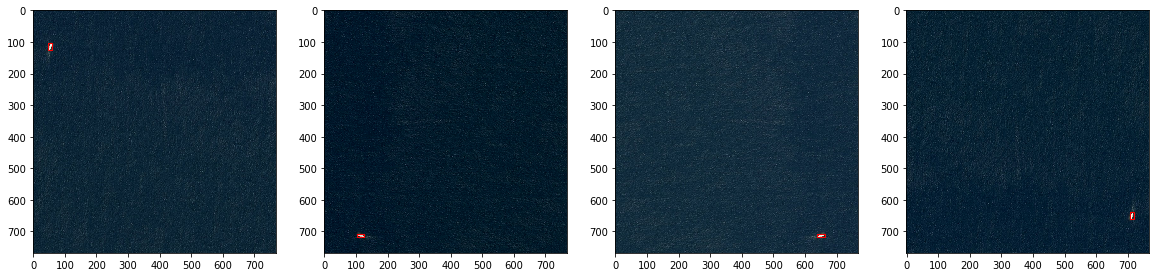

In [31]:
i = 0
fig_sz = (20, 20)
fig, axes = plt.subplots(1, 4, figsize=fig_sz)
for ax in axes.flatten():
    x,y = next(iter(md.aug_dl))
    img = denorm(x)[i]
    bboxes = to_np(y[i]).reshape(-1,4)
    bboxes = bboxes[np.sum(bboxes,1) != 0].tolist()
    draw_bbox_on_img(img, bboxes, ax=ax)

### anchor boxes

In [32]:
from anchor_box import plot_anchors, hw2corners, get_anchor_boxes

In [33]:
anc_grids = [12]
anc_zooms = [0.5, 1., 2]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]

In [34]:
anchors, grid_sizes, anchor_cnr, scales, anc_sizes = get_anchor_boxes(anc_grids, anc_zooms, anc_ratios)

In [35]:
anchors

Variable containing:
 0.0417  0.0417  0.0417  0.0417
 0.0417  0.0417  0.0417  0.0208
 0.0417  0.0417  0.0208  0.0417
               ⋮                
 0.9583  0.9583  0.1667  0.1667
 0.9583  0.9583  0.1667  0.0833
 0.9583  0.9583  0.0833  0.1667
[torch.FloatTensor of size 1296x4]

In [36]:
grid_sizes

Variable containing:
1.00000e-02 *
 8.3333
 8.3333
 8.3333
   ⋮    
 8.3333
 8.3333
 8.3333
[torch.FloatTensor of size 1296x1]

In [37]:
anchor_cnr

Variable containing:
 0.0208  0.0208  0.0625  0.0625
 0.0208  0.0312  0.0625  0.0521
 0.0312  0.0208  0.0521  0.0625
               ⋮                
 0.8750  0.8750  1.0417  1.0417
 0.8750  0.9167  1.0417  1.0000
 0.9167  0.8750  1.0000  1.0417
[torch.FloatTensor of size 1296x4]

In [38]:
scales

[(0.5, 0.5),
 (0.5, 0.25),
 (0.25, 0.5),
 (1.0, 1.0),
 (1.0, 0.5),
 (0.5, 1.0),
 (2.0, 2.0),
 (2.0, 1.0),
 (1.0, 2.0)]

In [39]:
anc_sizes

Variable containing:
 0.0417  0.0417
 0.0417  0.0208
 0.0208  0.0417
       ⋮        
 0.1667  0.1667
 0.1667  0.0833
 0.0833  0.1667
[torch.FloatTensor of size 1296x2]

In [40]:
k = len(scales);k

9

### model

![](../SSD.png)

model should be modified to multi head if different # of anchor grid will be used

(x - K + 2P / S) + 1

In [41]:
# total classes including background
n_cls = 2 

In [42]:
class StdConv(nn.Module):
    """conv - relu - batchnorm - dropout"""
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [43]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias, n_cls=1):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (n_cls+1)*k, 3, padding=1) 
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1) 
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [44]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        """
        SSD adds 6 more auxiliary convolution layers after the VGG16. 
        Five of them will be added for object detection.
        In three of those layers, we make 6 predictions instead of 4.
        In total, SSD makes 8732 predictions using 6 layers.
        
        """
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        return self.out(x)

In [45]:
head_reg4 = SSD_Head(k, -3.)

In [46]:
f_model=resnet34
sz=768

In [47]:
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

In [48]:
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

### check receptive field match with anchor orders

with multihead we can flatten the out with the same method and then concatenate grid1, grid2, ..., gridn

Receptive Field Moves from left to right

x1, y1, k1 

...

x2, y1, k1 

as opposed anchors

In [157]:
dummy_out = torch.from_numpy(np.arange(18*12*12).reshape(1, 18, 12, 12))

In [158]:
dummy_out


(0 ,0 ,.,.) = 
     0     1     2  ...      9    10    11
    12    13    14  ...     21    22    23
    24    25    26  ...     33    34    35
        ...          ⋱          ...       
   108   109   110  ...    117   118   119
   120   121   122  ...    129   130   131
   132   133   134  ...    141   142   143

(0 ,1 ,.,.) = 
   144   145   146  ...    153   154   155
   156   157   158  ...    165   166   167
   168   169   170  ...    177   178   179
        ...          ⋱          ...       
   252   253   254  ...    261   262   263
   264   265   266  ...    273   274   275
   276   277   278  ...    285   286   287

(0 ,2 ,.,.) = 
   288   289   290  ...    297   298   299
   300   301   302  ...    309   310   311
   312   313   314  ...    321   322   323
        ...          ⋱          ...       
   396   397   398  ...    405   406   407
   408   409   410  ...    417   418   419
   420   421   422  ...    429   430   431
   ...

(0 ,15,.,.) = 
  2160  2161  2162  ...   

In [159]:
dummy_out.shape

torch.Size([1, 18, 12, 12])

In [163]:
dummy_reshaped = dummy_out.permute(0,2,3,1).contiguous().view(1,-1,18//k)

In [164]:
# preds for loc x1, y1 after reshape
dummy_reshaped[:, :9]


(0 ,.,.) = 
     0   144
   288   432
   576   720
   864  1008
  1152  1296
  1440  1584
  1728  1872
  2016  2160
  2304  2448
[torch.LongTensor of size 1x9x2]

In [165]:
# preds for loc x2, y1 after reshape
dummy_reshaped[: 9:18]


(0 ,.,.) = 
     1   145
   289   433
   577   721
   865  1009
  1153  1297
  1441  1585
  1729  1873
  2017  2161
  2305  2449
[torch.LongTensor of size 1x9x2]

In [1677]:
# preds for loc x3, y1
dummy_out[:, :, 0, 0]



Columns 0 to 12 
    0   144   288   432   576   720   864  1008  1152  1296  1440  1584  1728

Columns 13 to 17 
 1872  2016  2160  2304  2448
[torch.LongTensor of size 1x18]

In [1679]:
# preds for loc x4, y2
dummy_out[:, :, 0, 1]



Columns 0 to 12 
    1   145   289   433   577   721   865  1009  1153  1297  1441  1585  1729

Columns 13 to 17 
 1873  2017  2161  2305  2449
[torch.LongTensor of size 1x18]

### Train

We begin by matching each ground truth box to the default box with the best
jaccard overlap (as in MultiBox [7]). Unlike MultiBox, we then match default boxes to
any ground truth with jaccard overlap higher than a threshold (0.5). This simplifies the
learning problem, allowing the network to predict high scores for multiple overlapping
default boxes rather than requiring it to pick only the one with maximum overlap.

In [51]:
from detect_utils import get_y, actn_to_bb
from detect_utils import jaccard
from detect_utils import map_to_ground_truth
from detect_utils import ssd_1_loss

In [52]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes
    
    def get_weight(self,x,t): return None

cls_loss = BCE_Loss(num_classes=n_cls)

In [53]:
def ssd_loss(pred, targ, alpha=1, print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls*alpha+lcs

In [54]:
layers_groups = learn.get_layer_groups()

In [56]:
layers_groups[2]

Sequential(
  (0): SSD_Head(
    (drop): Dropout(p=0.25)
    (sconv0): StdConv(
      (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (drop): Dropout(p=0.1)
    )
    (sconv2): StdConv(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (drop): Dropout(p=0.1)
    )
    (out): OutConv(
      (oconv1): Conv2d(256, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (oconv2): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [57]:
learn.lr_find()

  0%|          | 0/1219 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [76]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

In [77]:
learn.fit(lr, 20)

epoch      trn_loss   val_loss                          
    0      96.667706  739.330017
    1      119.706802 1545.899048                      
    2      107.846871 81.231995                        
    3      90.751178  14.318979                         
    4      72.824461  8.373572                          
    5      59.889707  6.619989                          
    6      50.602207  4.910463                          
    7      43.60114   3.68293                           
    8      38.170655  2.841321                          
    9      33.831802  2.194366                          
    10     30.268819  1.681962                          
    11     27.305579  1.306275                          
    12     24.802547  1.09277                           
    13     22.673074  1.078726                          
    14     20.827252  1.133763                          
    15     19.217266  1.177954                          
    16     17.790703  1.221825                          


KeyboardInterrupt: 

### test results

In [78]:
from detect_plots import draw_bbox, draw_text

In [79]:
x,y = next(iter(md.trn_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

In [80]:
b_clas.size(),b_bb.size()

(torch.Size([16, 1296, 2]), torch.Size([16, 1296, 4]))

In [213]:
idx=15
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

(Variable containing:
  0.8203  0.3177  0.8477  0.3646
  0.8542  0.3945  0.8685  0.4128
  0.8255  0.3112  0.8724  0.3906
  0.3672  0.4727  0.4062  0.5859
 [torch.FloatTensor of size 4x4], Variable containing:
  1
  1
  1
  1
 [torch.LongTensor of size 4])

In [214]:
actual_bb = to_np(bbox).copy()

In [215]:
#  min_y, min_x, max_y, max_x
a_ic = actn_to_bb(b_bboxi, anchors)

(array([1288.,    1.,    0.,    1.,    0.,    1.,    1.,    1.,    0.,    3.]),
 array([0.     , 0.09665, 0.19331, 0.28996, 0.38661, 0.48326, 0.57992, 0.67657, 0.77322, 0.86987, 0.96653]),
 <a list of 10 Patch objects>)

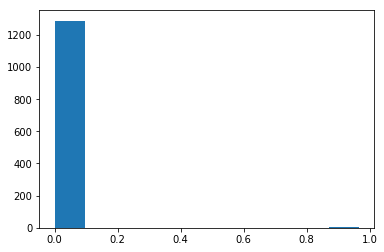

In [216]:
pred_proba = to_np(F.softmax(b_clasi))[:, 1]
plt.hist(pred_proba)

In [217]:
t = 0.5
pred_bbox_mask = pred_proba > t

In [218]:
pred_bbox_probas = np.round(pred_proba[pred_bbox_mask],2); pred_bbox_probas

array([0.97, 0.89, 0.88, 0.59, 0.74, 0.57], dtype=float32)

In [219]:
# corner preds
pred_bbox_corner = to_np(a_ic*sz).astype(int)[pred_bbox_mask]

In [220]:
pred_bbox_probas

array([0.97, 0.89, 0.88, 0.59, 0.74, 0.57], dtype=float32)

In [221]:
pred_bbox_corner

array([[303, 376, 336, 408],
       [304, 439, 336, 456],
       [296, 371, 344, 403],
       [240, 416, 272, 480],
       [680, 240, 728, 272],
       [624, 288, 656, 352]])

In [222]:
# remaining boxes
post_nms_idxs = []

In [223]:
# non max supression
sorted_idx = np.argsort(pred_bbox_probas)[::-1]

In [224]:
sorted_idx

array([0, 1, 2, 4, 3, 5])

In [183]:
def calc_iou(bb1, bb2):
    x1 = max(bb1[0], bb2[0]) 
    x2 = min(bb1[2], bb2[2]) 
    y1 = max(bb1[1], bb2[1]) 
    y2 = min(bb1[3], bb2[3]) 
    
    inter = max(0, x2 - x1)*max(0, y2 - y1)
    bb1_area = (bb1[2] - bb1[0])*(bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0])*(bb2[3] - bb2[1])
    union = bb1_area+bb2_area-inter
    return inter/union

In [184]:
def nms(sorted_idx, pred_bbox_corner):
    """apply non max supression after predictions"""
    post_nms_idxs = []
    for i in sorted_idx:
        if post_nms_idxs == []:
            post_nms_idxs.append(i)
            continue
        else:
            cand_bbox = pred_bbox_corner[i]
            add = True
            for idx in post_nms_idxs:
                curr_bbox = pred_bbox_corner[idx]
                iou = calc_iou(cand_bbox, curr_bbox)
                if iou > 0.5:
                    add = False
                    break
        if add: 
            post_nms_idxs.append(i)
    return post_nms_idxs

In [185]:
post_nms_idxs = nms(sorted_idx, pred_bbox_corner)
pred_bbox_corner = pred_bbox_corner[post_nms_idxs]
pred_bbox_probas = pred_bbox_probas[post_nms_idxs]

In [186]:
#actual
actual_bbox = actual_bb*sz

In [187]:
actual_bbox

array([[225., 598., 388., 697.]], dtype=float32)

In [188]:
# preds
pred_bbox_corner

array([[336, 624, 431, 656]])

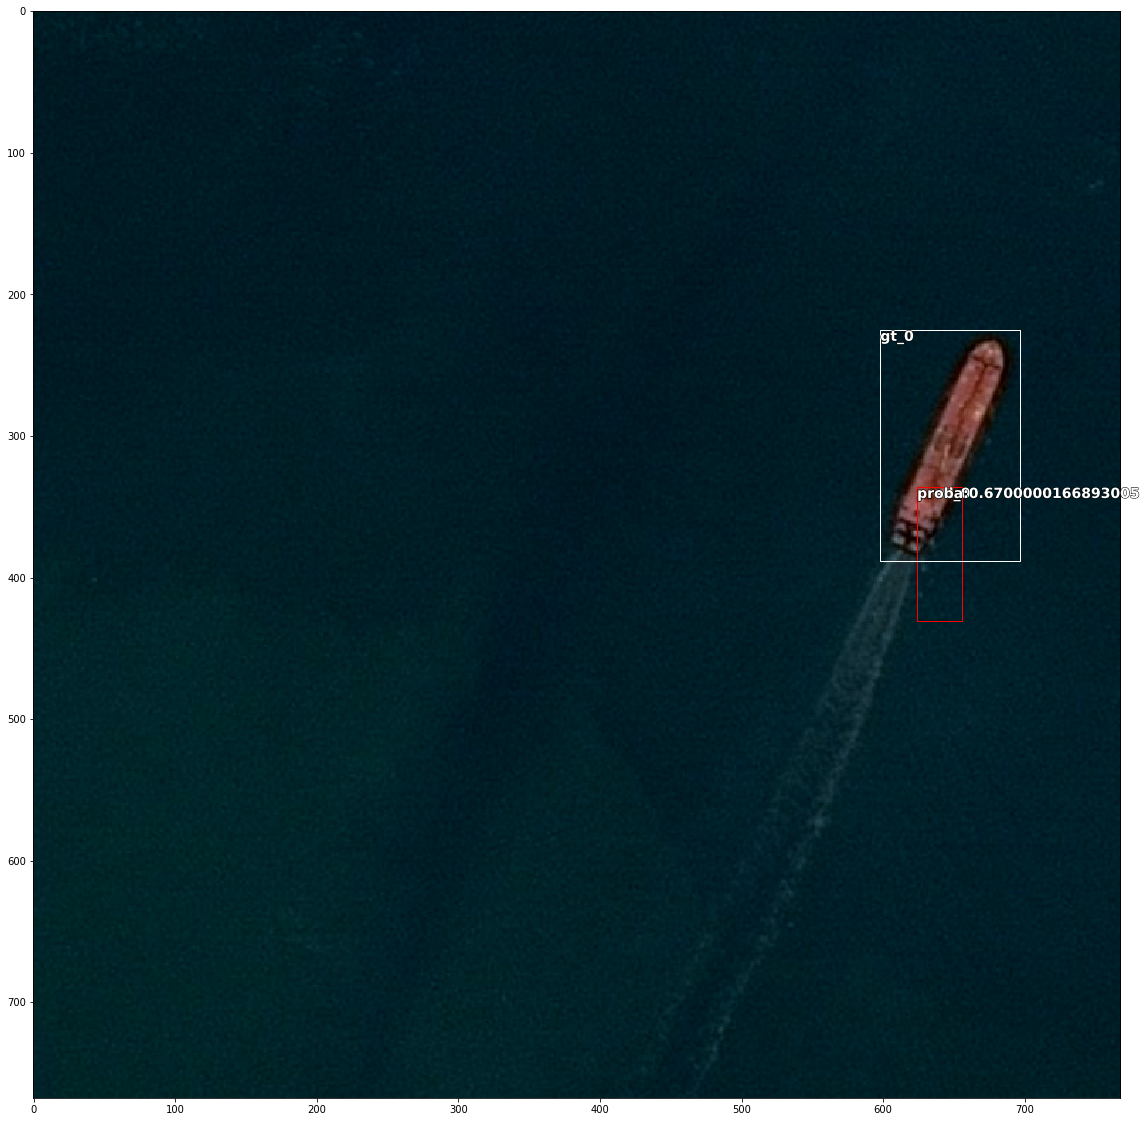

In [189]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
axes.imshow(ima)
for i, (bbox, proba) in enumerate(zip(pred_bbox_corner, pred_bbox_probas)): 
    draw_bbox(bbox, axes)
    draw_text(axes, bbox[:2][::-1], f"pred_{i}")
    draw_text(axes, bbox[:2][::-1], f"proba:{proba}")
    
for i, bbox in enumerate(actual_bbox): draw_bbox(bbox, axes, "white"); draw_text(axes, bbox[:2][::-1], f"gt_{i}")